In [410]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [411]:
# Todo:
# Prediction when finish goal 

# Import data

In [412]:
raw_data = pd.read_csv('./Data/Predict exploration completions - path unique Id.csv', skiprows = 14)

# Clean columns heads
raw_data.columns = ['landing_page', 'exit_page', 'client_id', 'medium', 'country',
       'device_cat', 'goal8completions', 'goal5completions',
       'new_users', 'users', 'pageviews', 'sessions', 'avg_time_on_page',
       'avg_session_duration', 'time_after_search']

# Add features
raw_data['goal8cr']= raw_data['goal8completions']/raw_data['sessions']
raw_data['goal5cr'] = raw_data['goal5completions']/raw_data['sessions']

# drop 
raw_data.drop(['time_after_search'], inplace = True, axis = 1 )

In [413]:
segment = pd.read_csv('./Data/cluster_handpicked.csv')
segment = segment[['country', 'new_cluster_cat']]
segment.columns = ['country', 'country_segment']

# Join Segment data and Data cleaning

In [414]:
change_country_name = {'Brunei Darussalam':'Brunei', 
                         'Cape Verde':'Cabo Verde', 
                         'Congo, Democratic Rep.':'Congo, Democratic Republic of the',
                        'Czech Republic':'Czechia', 
                         'Hong Kong SAR':'Hong Kong', 
                         'Iran, Islamic Rep.':'Iran',
                        'Korea, Rep.':'South Korea', 
                         'Kyrgyz Republic':'Kyrgyzstan', 
                         'Lao PDR':'Laos', 
                         'Russian Federation':'Russia',
                        'Swaziland':'Eswatini', 
                         'Taiwan, China':'Taiwan', 
                         'Viet Nam':'Vietnam',
                          'Trinidad and Tobago': 'Trinidad & Tobago',
                          'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                          'Congo': 'Congo - Kinshasa',
                      'Gambia, The':'Gambia'} 

# Change country names 
segment.country.replace(change_country_name, inplace = True)

In [415]:
joined_data = raw_data.merge(segment, left_on = 'country', right_on = 'country', how = 'left')

In [416]:
print('number of rows with missing data on segment: {}'\
      .format(len(joined_data[joined_data.country_segment.isna()])))

print('number of countries with missing data on segment: {}'\
      .format(len(joined_data[joined_data.country_segment.isna()].country.unique())))

print("number of rows with country as (not set): {}".format(len(joined_data[joined_data.country == '(not set)'])))

number of rows with missing data on segment: 595
number of countries with missing data on segment: 51
number of rows with country as (not set): 70


In [417]:
print('Countries with missing segment data: {}'\
      .format(joined_data[joined_data.country_segment.isna()].country.unique()))

Countries with missing segment data: ['Iraq' 'Palestine' '(not set)' 'Myanmar (Burma)' 'Western Sahara'
 'Belarus' 'Slovakia' 'North Macedonia' 'Antigua & Barbuda' 'Bolivia'
 'Curaçao' 'Puerto Rico' 'Fiji' 'Uzbekistan' 'Côte d’Ivoire' 'Macao'
 'Togo' 'Cuba' 'Afghanistan' 'Burkina Faso' 'St. Vincent & Grenadines'
 'Angola' 'Martinique' 'Bahamas' 'Congo - Kinshasa' 'Dominica' 'Réunion'
 'Maldives' 'Equatorial Guinea' 'Aruba' 'Barbados' 'Kosovo'
 'U.S. Virgin Islands' 'Guyana' 'Syria' 'Guam' 'Papua New Guinea'
 'Somalia' 'Belize' 'Sudan' 'Turkmenistan' 'Palau' 'American Samoa'
 'Suriname' 'Cayman Islands' 'St. Lucia' 'Djibouti' 'Libya' 'Cape Verde'
 'Bermuda' 'South Sudan']


## Clean joined_data

In [418]:
# Countries with missing segment data will be marked as Other 
missing_segment_index = joined_data[joined_data.country_segment.isna()].index
joined_data.loc[missing_segment_index, 'country_segment'] = 'Other'

# Feature Engineer

## Feature Engineer - New User boolean

Make new_users into boolean

In [419]:
# Replace new_users = 2 by 1 
index_newUsers = joined_data[joined_data.new_users >=1 ].index
joined_data.loc[index_newUsers, 'new_users'] = True

index_returningUsers = joined_data[joined_data.new_users == 0 ].index
joined_data.loc[index_returningUsers, 'new_users'] = False

In [420]:
# Delete medium blog rows (2 row)
joined_data.drop(joined_data[joined_data.medium == 'blog'].index, inplace = True)

In [421]:
joined_data.sample(2)

,landing_page,exit_page,client_id,medium,country,device_cat,goal8completions,goal5completions,new_users,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr,country_segment
39228,/learn/math,/learn/math/place-values/revision/place-names-...,414213481.2,organic,India,desktop,0,0,False,1,5,1,13.5,54.0,0.0,0.0,Low
45716,/math/ratios,/math/ratios,1452663938,cpc,India,desktop,0,0,True,1,1,1,0.0,0.0,0.0,0.0,Low


## Feature engineer - Unique sessions with landing page = exit page (page depth = 1)

In [422]:
joined_data[joined_data.sessions>50]

,landing_page,exit_page,client_id,medium,country,device_cat,goal8completions,goal5completions,new_users,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr,country_segment
7427,/collection/inDXV0w8-p1C,/collection/inDXV0w8-p1C,793092548.2,(none),Bangladesh,desktop,0,0,True,1,85,73,926.166667,152.246575,0.0,0.0,Low
7543,/community-library,/community-library,130226886.2,(none),Mauritania,desktop,0,0,False,1,58,57,441.000000,7.736842,0.0,0.0,Low
24267,/explore/2mzzFVDLuAj8?collection_id=53gXGLIR044l,/explore/2mzzFVDLuAj8?collection_id=53gXGLIR044l,1942190152,cpc,Nigeria,mobile,0,104,False,1,113,104,456.111111,39.471154,0.0,1.0,Low
31439,/explore/m0LGDfsrWo4c,/explore/m0LGDfsrWo4c,95781357.16,(none),Indonesia,desktop,0,147,False,1,157,147,1088.300000,74.034014,0.0,1.0,Low
39144,/get-started,/get-started,1621104838,organic,India,mobile,0,0,False,1,110,71,743.794872,408.549296,0.0,0.0,Low


In [423]:
# sessions with 1 page 
one_page_unique_sessions = joined_data[joined_data.landing_page == joined_data.exit_page]
print('There are {} unique sessions with 1 page only'.format(len(one_page_unique_sessions)))

usessions_1plus = len(joined_data) - len(one_page_unique_sessions)
print('There are only {} unique sessions with more than 1 pages opened, this accounts for {}% of total unique sessions'\
      .format(usessions_1plus, round(usessions_1plus/len(joined_data)*100)))


There are 39230 unique sessions with 1 page only
There are only 9892 unique sessions with more than 1 pages opened, this accounts for 20% of total unique sessions


Unique sessions with 1+ pages have slightly better Goal 8 CR (0.24 vs 0.17) but lower Goal 5 CR (0.64 vs 0.71)
Unique sessions with 1+ pages have fewer new users
Unique sessions with 1+ pages have more pageviews (almost 5x more) 
Unique sessions with 1+ pages have higher time on page (4.6 minutes vs. 1.3 minute)
Unique sessions with 1+ pages have higher avg. session duration (13 minutes vs. 3.5 minutes) 

In [424]:
joined_data[joined_data.landing_page != joined_data.exit_page].describe()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
count,9892.000000,9892.000000,9892.0,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000,9892.000000
mean,0.245653,0.658310,1.0,5.028508,1.049636,276.754208,785.655704,0.242261,0.645286
std,0.434935,0.498008,0.0,5.206037,0.475316,530.140600,1274.357676,0.427652,0.477461
min,0.000000,0.000000,1.0,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.0,2.000000,1.000000,23.867788,56.750000,0.000000,0.000000
50%,0.000000,1.000000,1.0,3.000000,1.000000,69.000000,229.000000,0.000000,1.000000
75%,0.000000,1.000000,1.0,6.000000,1.000000,283.062500,1002.000000,0.000000,1.000000
max,3.000000,4.000000,1.0,116.000000,32.000000,8811.000000,15660.000000,1.000000,1.000000


In [425]:
joined_data[joined_data.landing_page == joined_data.exit_page].describe()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
count,39230.000000,39230.000000,39230.0,39230.000000,39230.000000,39230.000000,39230.000000,39230.000000,39230.000000
mean,0.201733,0.899082,1.0,1.637701,1.241499,73.369589,212.533870,0.174001,0.712866
std,0.437582,1.270452,0.0,2.517965,1.384190,290.156447,491.414093,0.367262,0.449546
min,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,1.0,1.000000,1.000000,0.000000,6.000000,0.000000,1.000000
75%,0.000000,1.000000,1.0,2.000000,1.000000,0.000000,176.000000,0.000000,1.000000
max,26.000000,147.000000,1.0,174.000000,147.000000,9178.000000,13234.000000,1.000000,1.000000


In [426]:
### Label unique sessions with a name for later use
index_pagedeapth_not1 = joined_data[joined_data.landing_page != joined_data.exit_page].index
index_pagedeapth_1 = joined_data[joined_data.landing_page == joined_data.exit_page].index

joined_data.loc[index_pagedeapth_not1, 'pagedepth_1'] = False
joined_data.loc[index_pagedeapth_1, 'pagedepth_1'] = True

In [427]:
joined_data.drop(columns = ['users','sessions', 'goal8completions', 'goal5completions'],axis = 1).groupby('pagedepth_1').mean()

,pageviews,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
pagedepth_1,,,,,
False,5.028508,276.754208,785.655704,0.242261,0.645286
True,1.637701,73.369589,212.533870,0.174001,0.712866


Time after search for Sessions with pagedepth = 1 is close to 0, which suggests users in this group rarely search on the website. 

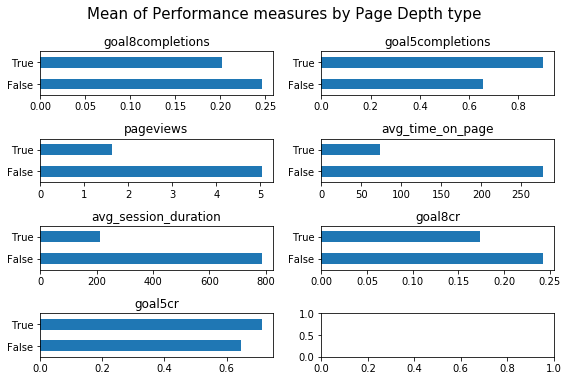

In [428]:
fig, axes = plt.subplots(4, 2, figsize=(8,5))

for col, ax in zip(num_col, axes.flatten()): 
    joined_data.groupby('pagedepth_1')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by Page Depth type', fontsize = 15, y = 1.05)
    
plt.tight_layout() # avoid chart overlap
plt.show()
    

## Feature Engineer - Link type

In [429]:
### Create exit_page_1 and landing_page_1: Extract the first level of link path ###

# some link does not contain slash (/), so I need to identify index of rows that I can extract link type
df_with_link = joined_data[(joined_data['landing_page'] != '(not set)') & (joined_data['landing_page'] != '/' ) ]

#------Landing page----#
# Extract first path level in link. Only links not (not set) or /
joined_data.loc[df_with_link.index, 'landing_page_1'] = joined_data.loc[df_with_link.index,'landing_page']\
                                                    .apply(lambda x: x.split('/')[1])
# if link is (not set) or /, copy from link
joined_data.loc[joined_data.landing_page_1.isna(), 'landing_page_1'] = joined_data['landing_page']


#------Exit page----#
# Extract first path level in link. Only links not (not set) or /
joined_data.loc[df_with_link.index, 'exit_page_1'] = joined_data.loc[df_with_link.index,'exit_page']\
                                                    .apply(lambda x: x.split('/')[1])

# if link is (not set) or /, copy from link
joined_data.loc[joined_data.exit_page_1.isna(), 'exit_page_1'] = test['exit_page']

In [430]:
### Create page link type column  ###

def extract_link_type(data, origin_col, new_col):
    data.loc[data[origin_col].str.contains('fbclid'), new_col] = 'Facebook lead'
    #data.loc[data[origin_col].str.contains('translate'), new_col] = 'translate'
    data.loc[data[origin_col].str.contains('dashboard'), new_col] = 'dashboard'
    data.loc[data[origin_col].str.contains('ref'), new_col] = 'website referral'
    data.loc[data[origin_col].isin(['explore', 'ewxplore',  'explor', 'exploration','?explore',
                                    'explore', 'EXPLORE',  'explorer', 'expolre','explor']),
                                     new_col] = 'exploration'
    data.loc[data[origin_col].isin(['exploerhandler','explorhandler', 'explorehandler','explorer_data_handler'])] = 'explore handler'
    data.loc[data[origin_col].isin(['library', 'community-librar,,']), new_col] = 'library'
    data.loc[data[origin_col].str.contains('dashboard'), new_col] = 'dashboard'
    data.loc[data[origin_col].str.contains('signup'), new_col] = 'signup'
    data.loc[data[origin_col].str.contains('dashboard'), new_col] = 'dashboard'
    data.loc[data[origin_col].str.contains('librar'), new_col] = 'library'
    data.loc[data[origin_col].str.contains('thanks'), new_col] = 'thank you'
    data.loc[data[origin_col].str.contains('privacy'), new_col] = 'privacy'
    data.loc[data[origin_col].str.contains('editor'), new_col] = 'editor' # skill editor, topic editor, story editor
    data.loc[data[origin_col].str.contains('teach'), new_col] = 'teach'
    data.loc[data[origin_col].str.contains('collection'), new_col] = 'collection'
    data.loc[data[origin_col].str.contains('contact'), new_col] = 'contact'
    data.loc[data[origin_col].str.contains('create'), new_col] = 'create'
    data.loc[data[origin_col].str.contains('admin'), new_col] = 'admin'
    data.loc[data[origin_col].str.contains('learn'), new_col] = 'learn'
    data.loc[data[origin_col].str.contains('classroom'), new_col] = 'classroom'
    data.loc[data[origin_col].isin(['get-started','get_started']), new_col] = 'get-started'
    data.loc[data[origin_col].isin(['donate','donaete']), new_col] = 'donate'
    data.loc[data[origin_col].str.contains('math'), new_col] = 'math'
    data.loc[data[origin_col].str.contains('profile'), new_col] = 'profile'
    data.loc[data[origin_col].str.contains('embed'), new_col] = 'embed'
    data.loc[data[origin_col].str.contains('terms'), new_col] = 'terms'
    data.loc[data[origin_col].str.contains('topic'), new_col] = 'topic'
    data.loc[data[origin_col].str.contains('notification'), new_col] = 'notification'
    data.loc[data[origin_col].str.contains('story'), new_col] = 'story'
    data.loc[data[origin_col].str.contains('parents'), new_col] = 'parents'
    data.loc[data[origin_col].str.contains('volunteer'), new_col] = 'volunteer'
    data.loc[data[origin_col].str.contains('search'), new_col] = 'search'
    data.loc[data[origin_col].str.contains('about'), new_col] = 'about'
    data.loc[data[origin_col].str.contains('(not set)'), new_col] = '(not set)'
    data.loc[data[origin_col].str.contains('/'), new_col] = 'homepage'
    

In [431]:
# Landing Page
extract_link_type(joined_data, 'landing_page_1', 'landing_page_type')
joined_data.loc[joined_data.landing_page_type.isna(), 'landing_page_type'] = 'Other'

# Exit Page
extract_link_type(joined_data, 'exit_page_1', 'exit_page_type')
joined_data.loc[joined_data.exit_page_type.isna(), 'exit_page_type'] = 'Other'

joined_data

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,landing_page,exit_page,client_id,medium,country,device_cat,goal8completions,goal5completions,new_users,users,...,avg_time_on_page,avg_session_duration,goal8cr,goal5cr,country_segment,pagedepth_1,landing_page_1,exit_page_1,landing_page_type,exit_page_type
0,(not set),(not set),1001344398,(none),United Kingdom,desktop,0,1,False,1,...,0,0,0,1,High,True,(not set),(not set),(not set),(not set)
1,(not set),(not set),1003193340,organic,United Kingdom,desktop,0,0,False,1,...,0,0,0,0,High,True,(not set),(not set),(not set),(not set)
2,(not set),(not set),1005936440,organic,United States,desktop,1,1,False,1,...,0,215,1,1,High,True,(not set),(not set),(not set),(not set)
3,(not set),(not set),1007166396,(none),United Kingdom,desktop,1,3,False,1,...,0,10,0.333333,1,High,True,(not set),(not set),(not set),(not set)
4,(not set),(not set),1007742325,(none),United Kingdom,desktop,1,1,False,1,...,0,1061,1,1,High,True,(not set),(not set),(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49119,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,1644450400,(none),India,mobile,0,0,False,1,...,0,0,0,0,Low,True,translate_c?depth=3&hl=hi&nv=1&prev=search&pto...,translate_c?depth=3&hl=hi&nv=1&prev=search&pto...,search,search
49120,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,/translate_c?depth=4&hl=hi&nv=1&prev=search&pt...,1644450400,(none),India,mobile,0,0,False,1,...,909.5,1819,0,0,Low,False,translate_c?depth=3&hl=hi&nv=1&prev=search&pto...,translate_c?depth=4&hl=hi&nv=1&prev=search&pto...,search,search
49121,/volunteer,/,439611576.2,(none),United States,desktop,0,0,False,1,...,5,5,0,0,High,False,volunteer,,volunteer,Other
49122,/Y3JlYXRvci,/create/siF9qxHO173O,315744473.2,(none),Netherlands,desktop,0,0,True,1,...,1,3,0,0,High,False,Y3JlYXRvci,create,Other,create


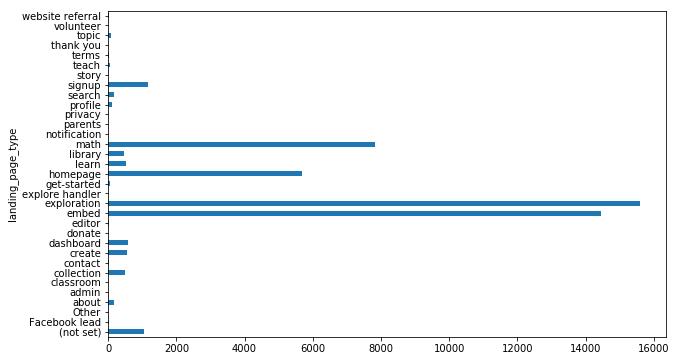

In [432]:
plt.subplots(figsize=(10,6))

joined_data.groupby('landing_page_type')['landing_page'].count().plot(kind='barh')

In [446]:
### Group link type level 2
learning_paths = ['classroom', 'embed', 'learn', 'math', 'exploration']
engaging_paths =  ['admin', 'profile',  'donate', 'explore handler', 'library', 
                   'create', 'collection','signup', 
                   'editor', 'thank you', 'Other', 'notification', 'dashboard']
info_seeking_paths =  ['privacy', 'search', 'story', 'terms', 'volunteer', 'topic',
                       'about', 'Facebook lead', 'website referral', 'parents','contact','get-started']

#---Landing page---#

joined_data.loc[joined_data['landing_page_type'].isin(learning_paths),
                'landing_page_type_2'] = 'learning'
joined_data.loc[joined_data['landing_page_type'].isin(engaging_paths),
                'landing_page_type_2'] = 'engaging'
joined_data.loc[joined_data['landing_page_type'].isin(info_seeking_paths),
                'landing_page_type_2'] = 'info_seeking'

joined_data.loc[joined_data['landing_page_type'] == '(not set)',
                'landing_page_type_2'] = '(not set)'
joined_data.loc[joined_data['landing_page_type'] == 'homepage',
                'landing_page_type_2'] = 'homepage'

#---Exit page---#
joined_data.loc[joined_data['exit_page_type'].isin(learning_paths),
                'exit_page_type_2'] = 'learning'
joined_data.loc[joined_data['exit_page_type'].isin(engaging_paths),
                'exit_page_type_2'] = 'engaging'
joined_data.loc[joined_data['exit_page_type'].isin(info_seeking_paths),
                'exit_page_type_2'] = 'info_seeking'

joined_data.loc[joined_data['exit_page_type'] == '(not set)',
                'exit_page_type_2'] = '(not set)'
joined_data.loc[joined_data['exit_page_type'] == 'homepage',
                'exit_page_type_2'] = 'homepage'

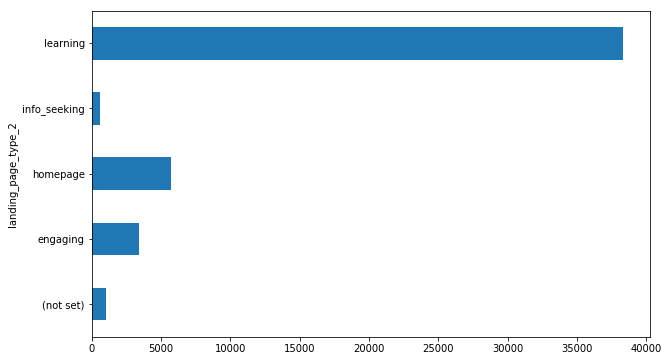

In [445]:
plt.subplots(figsize=(10,6))

joined_data.groupby('landing_page_type_2')['landing_page'].count().plot(kind='barh')

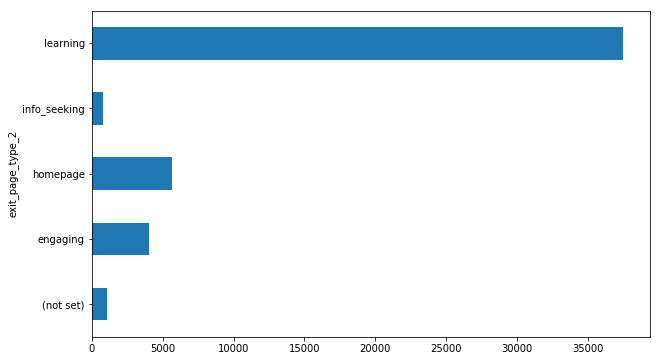

In [447]:
plt.subplots(figsize=(10,6))

joined_data.groupby('exit_page_type_2')['landing_page'].count().plot(kind='barh')

# EDA

In [132]:
print('There are {} unique landing pages'.format(len(joined_data['landing_page'].unique())))
print('There are {} unique exit pages'.format(len(joined_data['exit_page'].unique())))
print('There are {} unique client id'.format(len(joined_data['client_id'].unique())))
print('There are {} unique countries'.format(len(joined_data['country'].unique())))
print('There are {} unique device categories'.format(len(joined_data['device_cat'].unique())))
print('There are {} unique mediums'.format(len(joined_data['medium'].unique())))

There are 1369 unique landing pages
There are 2097 unique exit pages
There are 37518 unique client id
There are 177 unique countries
There are 3 unique device categories
There are 5 unique mediums


In [133]:
row_count = len(joined_data)
unique_ids_count = len(joined_data['client_id'].unique())
ids_different_page = row_count-unique_ids_count

print('Because there are {} rows in this data set while there are only {} unique ids, {} ids opened Oppia via different landing/exit page'\
          .format(row_count, unique_ids_count, ids_different_page))


Because there are 49122 rows in this data set while there are only 37518 unique ids, 11604 ids opened Oppia via different landing/exit page


In [134]:
joined_data.describe()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
count,49122.000000,49122.000000,49122.0,49122.000000,49122.000000,49122.000000,49122.000000,49122.000000,49122.000000
mean,0.210578,0.850596,1.0,2.320528,1.202862,114.326403,327.946947,0.187747,0.699257
std,0.437400,1.161152,0.0,3.517088,1.257598,361.221647,756.762547,0.381175,0.456106
min,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,1.0,1.000000,1.000000,0.000000,25.000000,0.000000,1.000000
75%,0.000000,1.000000,1.0,2.000000,1.000000,30.000000,283.000000,0.000000,1.000000
max,26.000000,147.000000,1.0,174.000000,147.000000,9178.000000,15660.000000,1.000000,1.000000


## Descriptive Stats by Groups

### Descriptive Stats by Segment


In [135]:
joined_data.groupby('country_segment').mean()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
country_segment,,,,,,,,,
High,0.262218,0.908106,1.0,2.138991,1.185201,125.406943,365.944892,0.237048,0.761639
Low,0.119005,0.619893,1.0,2.657820,1.235503,102.623188,295.160246,0.105534,0.484959
Mid,0.137870,0.929243,1.0,2.595322,1.229666,89.154217,237.225074,0.111741,0.736712
Other,0.080672,0.494118,1.0,2.255462,1.198319,95.496416,208.118025,0.074090,0.418487


In [136]:
num_col = joined_data.drop(['users','sessions'], axis = 1).select_dtypes(include=['int64','float64']).columns

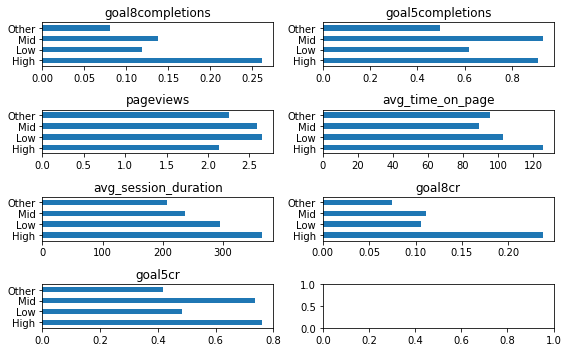

In [137]:
fig, axes = plt.subplots(4, 2, figsize=(8,5))

for col, ax in zip(num_col, axes.flatten()): 
    joined_data.groupby('country_segment')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by Country Segment', fontsize = 15, y = 1.05)
plt.tight_layout() # avoid chart overlap
plt.show()
    

### Descriptive Stats by Medium


In [144]:
joined_data.groupby('medium').mean()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
medium,,,,,,,,,
(none),0.318945,1.010392,1.0,2.067679,1.273115,149.769593,434.380114,0.282143,0.797534
cpc,0.040638,0.273035,1.0,2.289403,1.076337,50.501208,167.496751,0.037505,0.239980
email,0.375000,1.375000,1.0,1.500000,1.437500,107.656250,286.614583,0.343750,0.937500
organic,0.108623,0.530080,1.0,3.908200,1.191845,102.273140,383.056214,0.101290,0.466993
referral,0.251744,1.087587,1.0,1.807749,1.212082,121.743366,302.459437,0.223345,0.893407


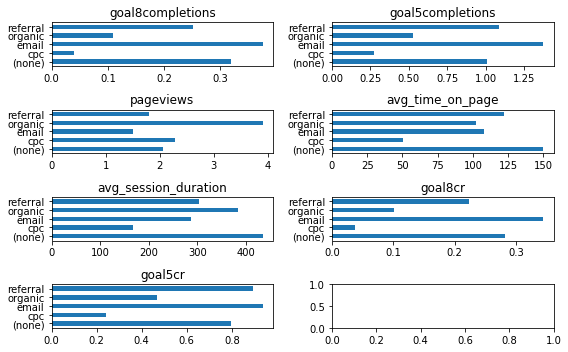

In [145]:
fig, axes = plt.subplots(4, 2, figsize=(8,5))

for col, ax in zip(num_col, axes.flatten()): 
    joined_data.groupby('medium')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by Medium type', fontsize = 15, y = 1.05)
    
plt.tight_layout() # avoid chart overlap
plt.show()
    

### Descriptive Stats by Device category

In terms of lesson completion rate, users on desktop have higher goal 8 completion rate

Mobile is having the worst engagement stats (sessions and page view duration)


In [124]:
joined_data.groupby('device_cat').mean()

,goal8completions,goal5completions,new_users,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
device_cat,,,,,,,,,,
desktop,0.236485,0.828853,0.710298,1.0,2.406436,1.192102,122.610494,372.268375,0.213639,0.693007
mobile,0.131010,0.920209,0.872387,1.0,2.031272,1.232666,86.621520,186.844207,0.107900,0.723786
tablet,0.163722,0.851590,0.746761,1.0,2.508834,1.266196,129.939513,315.156831,0.145310,0.638424


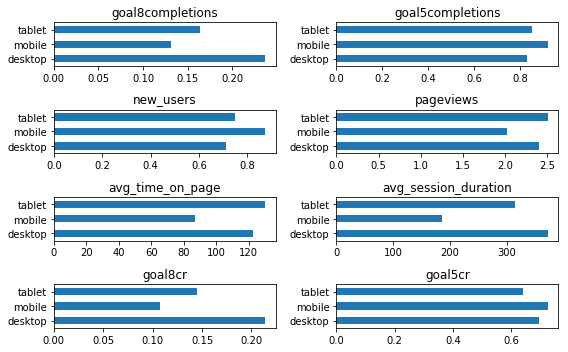

In [125]:
fig, axes = plt.subplots(4, 2, figsize=(8,5))

for col, ax in zip(num_col, axes.flatten()): 
    joined_data.groupby('device_cat')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by Device Category', fontsize = 15, y = 1.05)
    
plt.tight_layout() # avoid chart overlap
plt.show()
    

### Descriptive stats by New Users

Attracting users to come back is very important. Returning users are more likely to complete explorations. They also engage better (longer pageview time, longer session duration)

In [146]:
joined_data.groupby('new_users').mean()

,goal8completions,goal5completions,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
new_users,,,,,,,,,
False,0.275468,0.895534,1.0,3.353675,1.320609,169.770149,560.211841,0.246942,0.697161
True,0.188810,0.835522,1.0,1.973955,1.163364,95.727584,250.032788,0.167889,0.699960


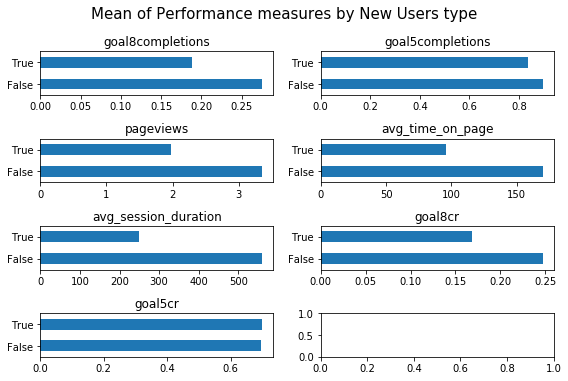

In [166]:
fig, axes = plt.subplots(4, 2, figsize=(8,5))

for col, ax in zip(num_col, axes.flatten()): 
    joined_data.groupby('new_users')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by New Users type', fontsize = 15, y = 1.05)
    
plt.tight_layout() # avoid chart overlap
plt.show()
    

## Exploration Completions (Dependent variable)

In [126]:
joined_data.drop(['users'], axis = 1).corr()

,goal8completions,goal5completions,new_users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr
goal8completions,1.000000,0.212219,-0.085925,0.096398,0.069489,0.263434,0.390477,0.918305,0.306784
goal5completions,0.212219,1.000000,-0.022415,0.294966,0.732722,0.122713,0.064903,0.110155,0.471332
new_users,-0.085925,-0.022415,1.000000,-0.170137,-0.054229,-0.088900,-0.177764,-0.089947,0.002661
pageviews,0.096398,0.294966,-0.170137,1.000000,0.440386,0.135533,0.347243,0.038740,0.011854
sessions,0.069489,0.732722,-0.054229,0.440386,1.000000,0.078145,-0.009556,-0.031825,0.016540
avg_time_on_page,0.263434,0.122713,-0.088900,0.135533,0.078145,1.000000,0.586053,0.260447,0.135269
avg_session_duration,0.390477,0.064903,-0.177764,0.347243,-0.009556,0.586053,1.000000,0.433059,0.188586
goal8cr,0.918305,0.110155,-0.089947,0.038740,-0.031825,0.260447,0.433059,1.000000,0.316981
goal5cr,0.306784,0.471332,0.002661,0.011854,0.016540,0.135269,0.188586,0.316981,1.000000


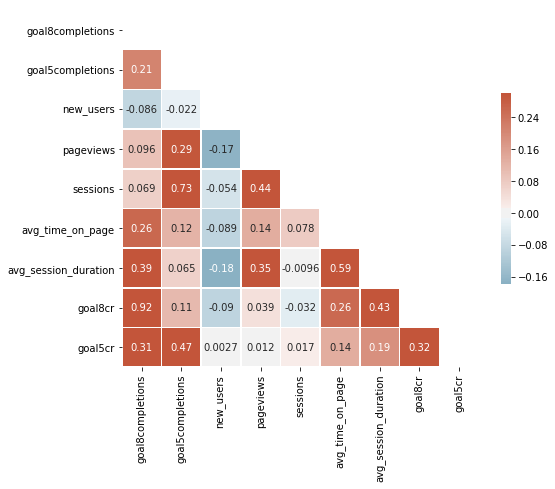

In [127]:
# Compute the correlation matrix
corr = joined_data.drop(['users'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Exploration Completion Rate:
- Positively correlate with avg_time_on_page and avg_session_duration


## Sessions
There is only 5791 unique ids used Oppia for more than once in 3 months-time

#### Created new feature Exploration_completed

In [170]:
#Marked if any unique session has goal8completions as completed (true)
completed_index = joined_data[joined_data.goal8completions > 0].index
joined_data['exploration_completed'] = False 
joined_data.loc[completed_index,'exploration_completed'] = True

Text(0.5, 1.0, 'Unique sessions that completed exploration is only 1/4 of total sessions')

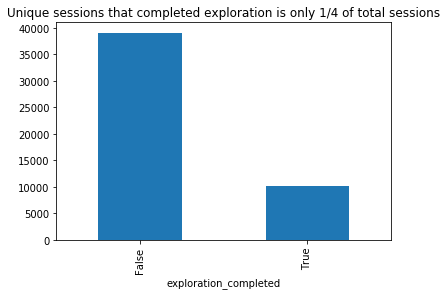

In [185]:
joined_data.groupby('exploration_completed')['client_id'].count().plot(kind = 'bar')
plt.title('Unique sessions that completed exploration is only 1/4 of total sessions')

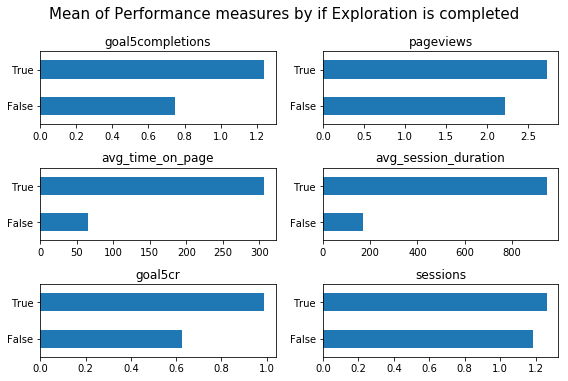

In [186]:
fig, axes = plt.subplots(3, 2, figsize=(8,5))

for col, ax in zip(['goal5completions', 'pageviews', 'avg_time_on_page',
       'avg_session_duration', 'goal5cr','sessions'], axes.flatten()): 
    joined_data.groupby('exploration_completed')[col].mean().plot(kind = 'barh', ax = ax)
    ax.set_title('{}'.format(col))
    ax.set_ylabel('')
    
fig.suptitle('Mean of Performance measures by if Exploration is completed', fontsize = 15, y = 1.05)
    
plt.tight_layout() # avoid chart overlap
plt.show()
    

When exploration is completed, Goal 4 completions averages at 1.2, which means on average, users opened more than 1 exploration before completing an exploration. 

In [236]:
joined_data

,landing_page,exit_page,client_id,medium,country,device_cat,goal8completions,goal5completions,new_users,users,pageviews,sessions,avg_time_on_page,avg_session_duration,goal8cr,goal5cr,country_segment,exploration_completed,pagedepth_1
0,(not set),(not set),1001344398,(none),United Kingdom,desktop,0,1,False,1,0,1,0.0,0.0,0.000000,1.0,High,False,True
1,(not set),(not set),1003193340,organic,United Kingdom,desktop,0,0,False,1,0,1,0.0,0.0,0.000000,0.0,High,False,True
2,(not set),(not set),1005936440,organic,United States,desktop,1,1,False,1,0,1,0.0,215.0,1.000000,1.0,High,True,True
3,(not set),(not set),1007166396,(none),United Kingdom,desktop,1,3,False,1,0,3,0.0,10.0,0.333333,1.0,High,True,True
4,(not set),(not set),1007742325,(none),United Kingdom,desktop,1,1,False,1,0,1,0.0,1061.0,1.000000,1.0,High,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49119,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,1644450400,(none),India,mobile,0,0,False,1,1,1,0.0,0.0,0.000000,0.0,Low,False,True
49120,/translate_c?depth=3&hl=hi&nv=1&prev=search&pt...,/translate_c?depth=4&hl=hi&nv=1&prev=search&pt...,1644450400,(none),India,mobile,0,0,False,1,3,1,909.5,1819.0,0.000000,0.0,Low,False,False
49121,/volunteer,/,439611576.2,(none),United States,desktop,0,0,False,1,2,1,5.0,5.0,0.000000,0.0,High,False,False
49122,/Y3JlYXRvci,/create/siF9qxHO173O,315744473.2,(none),Netherlands,desktop,0,0,True,1,3,1,1.0,3.0,0.000000,0.0,High,False,False


In [237]:
data_studio_df = joined_data.copy()

In [239]:
data_studio_df.to_csv('datastudiodf.csv', index=False)